## Results of Test Runs of Diffprep (Topup and Eddy)

Have a look at the output from diffprep for two example datasets and see whether the distrotion correction looks OK and whether the inferred field maps have the correct sense and scaling.

In [1]:
# Boiler plate
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
def show_slice(filename, z_locn=5, t_idx=0, cmap='viridis', centred=False, ax=None):
    '''
    Load the image and collect the data and orientation information
        filename:  nifti file loadable by nibabel
        z_locn:    slice index from *centre* of image
        t_idx:     time index from start of series
        cmap:      colour map to use
        centred:   centre data range for use (with diverging colour map)
        ax:        axes to display slice on (default - current axes)
    '''
    # Load file NB weird nifti memory layout (x, -y, z, t)
    img  = nib.load(filename)
    data = img.get_data()
    if data.ndim == 4:
        data = data[:, :, :, t_idx]
    aff = img.affine

    # Find the centre of the brain matrix
    ctr = np.round(np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]).astype(int)

    # Plot the data
    vmin, vmax = np.min(data), np.max(data)
    
    if centred:
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax
    if ax is None:
        ax = plt.gca()
    ax.imshow(
        np.rot90(data[:, :, ctr[2] + z_locn]),
        cmap=cmap, vmin=vmin, vmax=vmax
    )
    ax.set_axis_off()


### First Dataset 
Data written by `./test_diffprep_script`.

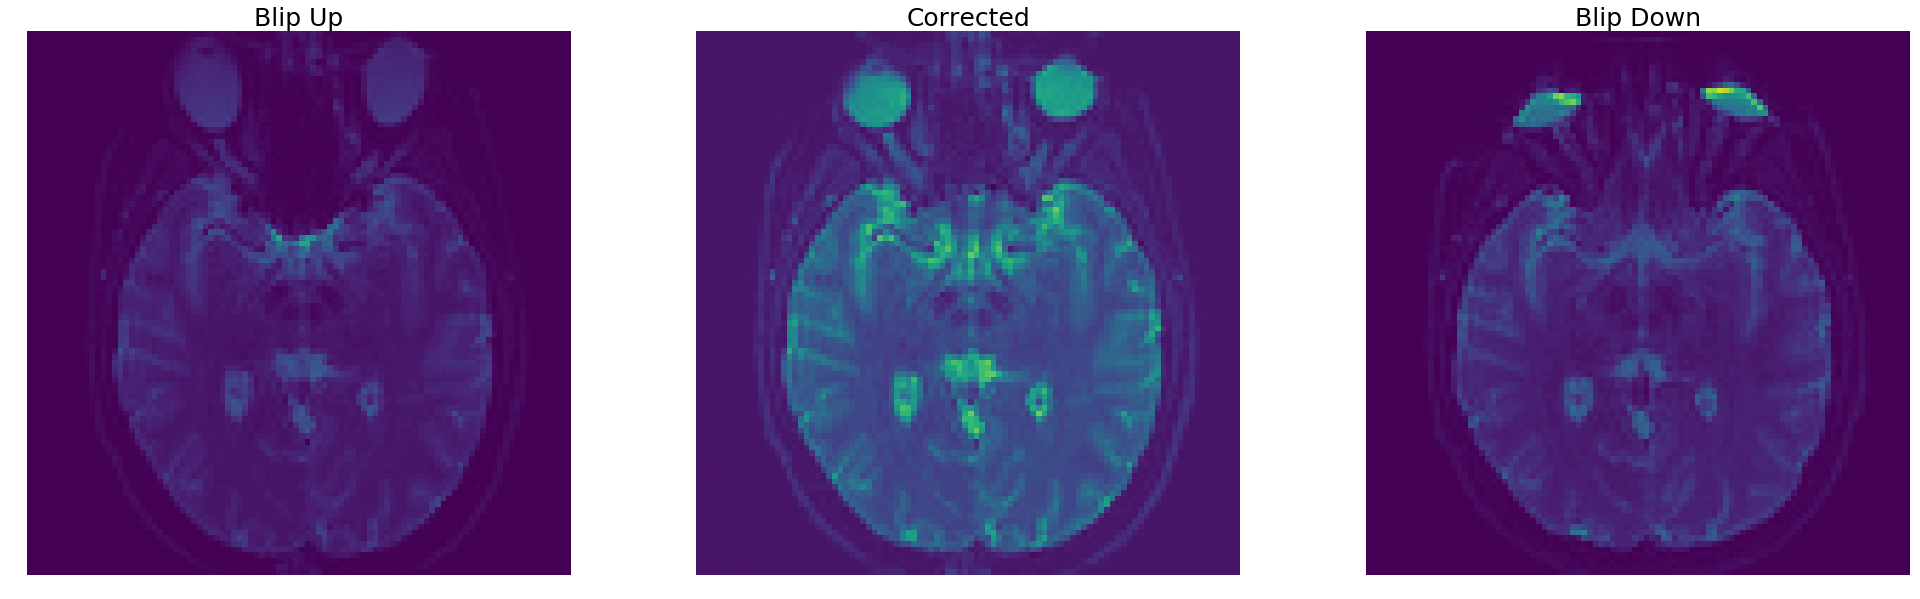

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(34, 10))

show_slice("dataset1/blipup.nii.gz",   z_locn=-6, t_idx=0, ax=axs[0])
show_slice("dataset1-out/data.nii.gz", z_locn=-6, t_idx=0, ax=axs[1])
show_slice("dataset1/blipdown.nii.gz", z_locn=-6, t_idx=0, ax=axs[2])
for i, s in enumerate(['Blip Up', 'Corrected', 'Blip Down']):
    axs[i].set_title(s, fontsize=25) 

The correction seems at least to have the right sense. It appears half way between the blip up and blip down.

The method is insensitive though to both the sense and the scaling of the gradient when it comes to producing corrected images. The field map on the other hand could be incorrectly signed or scaled.

The other outputs are a brain mask, a field map and an eddy current parameters file. It's not clear how these are used and whether they have to be correctly scaled.

In the [topup documentation](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/TOPUP/TopupUsersGuide) the sense of the phase encoding blip is supposed to be with repect to increasing pixel coordinate and we assume that this is also true for the field declared in the DICOM header and propagated to the nifti description field. However, if we use this field directly then the sense of the inferrred field error seems inverted.

The discrepancy may be due to the flipping of the y-axis in the nifti data organization. The relation between nifti and standard dicom data layout seems to be `nifti_pixels[:,::-1,:].T == dicom_pixels`, a left handed system with the y-axis being flipped so it goes from bottom to top instead of top to bottom.

We should therefore take the phase encoding sense from the DICOM and we should flip it if and only if the phase enconding is on the COL axis.

With that modification we have the the following field map.

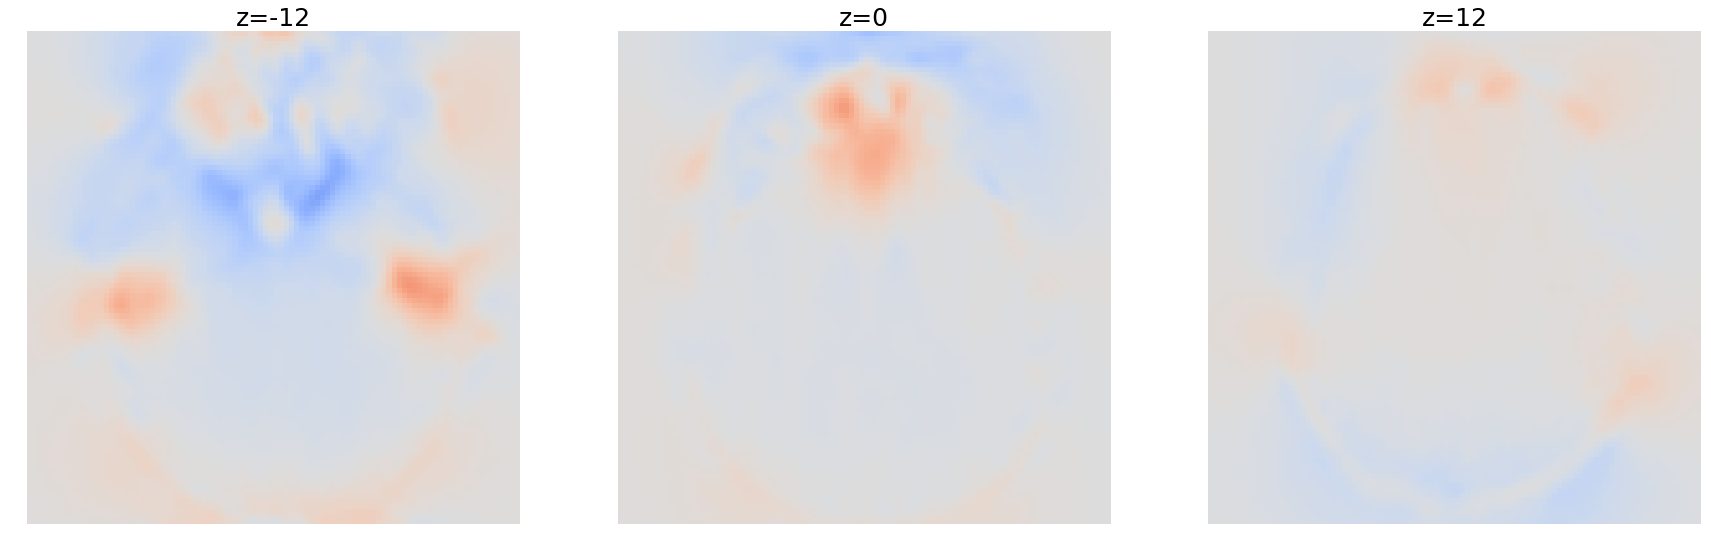

In [4]:
zs    = [-12, 0, 12]
figsz = 10
fig, axs = plt.subplots(1, len(zs), figsize=(figsz*len(zs), figsz))

for z, ax in zip(zs, axs):
    show_slice("dataset1-out/topup_field.nii.gz", z_locn=z, t_idx=0, cmap='coolwarm', centred=True, ax=ax)
    ax.set_title("z=%d" % z, fontsize=25)

OK, we have flipped the sense of this when we created the acq parameters file and the sense of the field maps looks correct - the field should be higher in the ear canals.

We'll still need to confirm that there is no flip required when the phase encode axis is ROW.

### Second Dataset

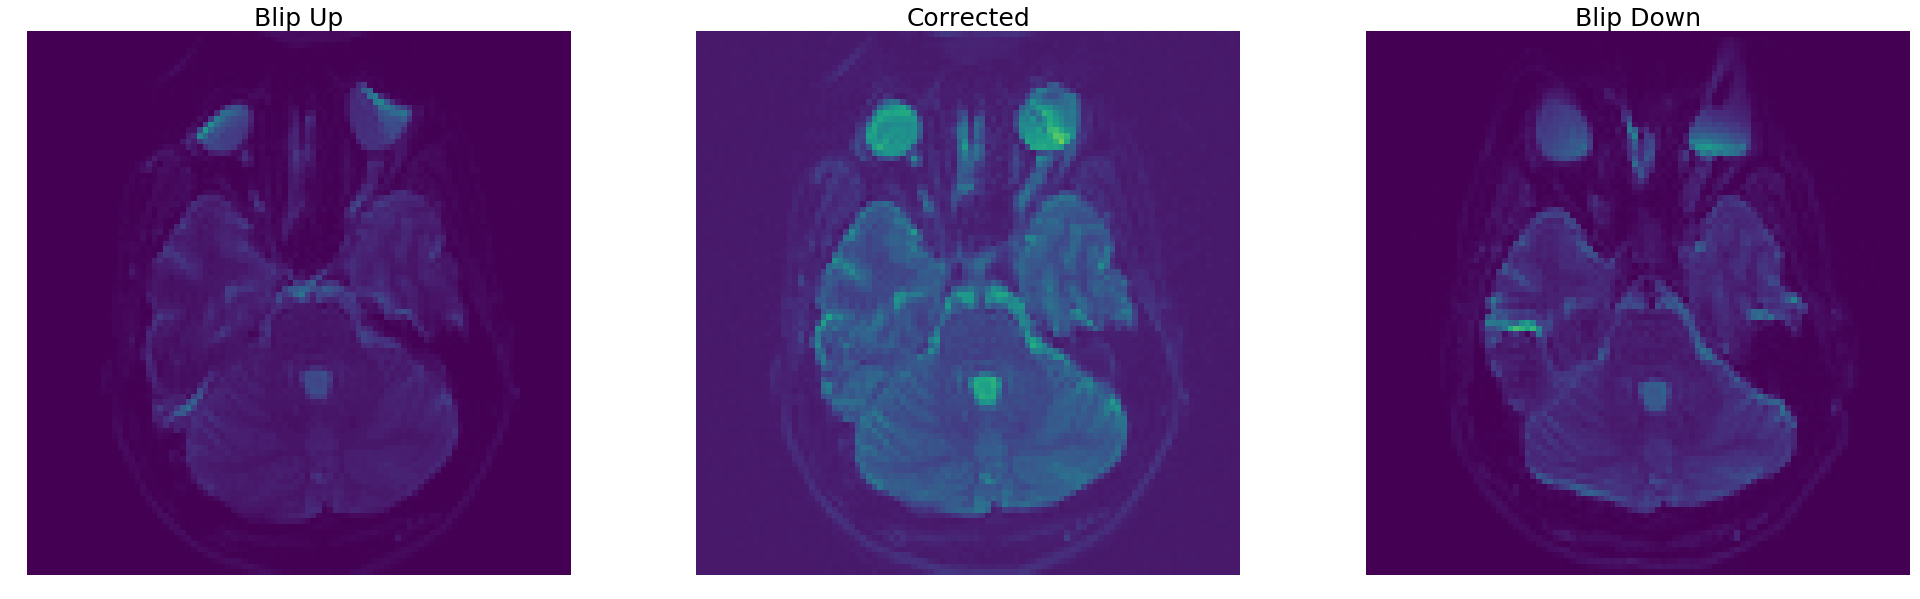

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(34, 10))

show_slice("dataset2/AP/s016a001.nii.gz", z_locn=-6, t_idx=0, ax=axs[0])
show_slice("dataset2-out/data.nii.gz",    z_locn=-6, t_idx=0, ax=axs[1])
show_slice("dataset2/PA/s022a001.nii.gz", z_locn=-6, t_idx=0, ax=axs[2])

for i, s in enumerate(['Blip Up', 'Corrected', 'Blip Down']):
    axs[i].set_title(s, fontsize=25)

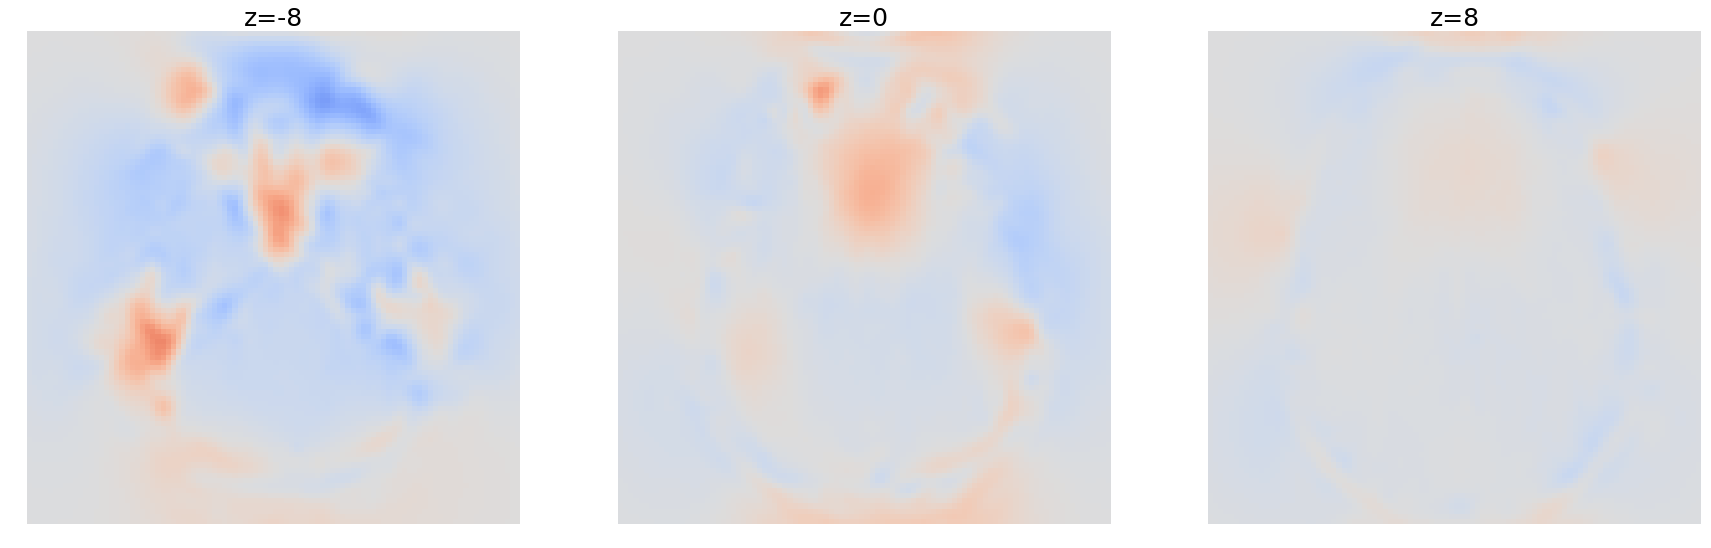

In [6]:
zs    = [-8, 0, 8]
figsz = 10
fig, axs = plt.subplots(1, len(zs), figsize=(figsz*len(zs), figsz))

for z, ax in zip(zs, axs):
    show_slice("dataset2-out/topup_field.nii.gz", z_locn=z, t_idx=0, cmap='coolwarm', centred=True, ax=ax)
    ax.set_title("z=%d" % z, fontsize=25)

### Third Dataset
With Zoomit.

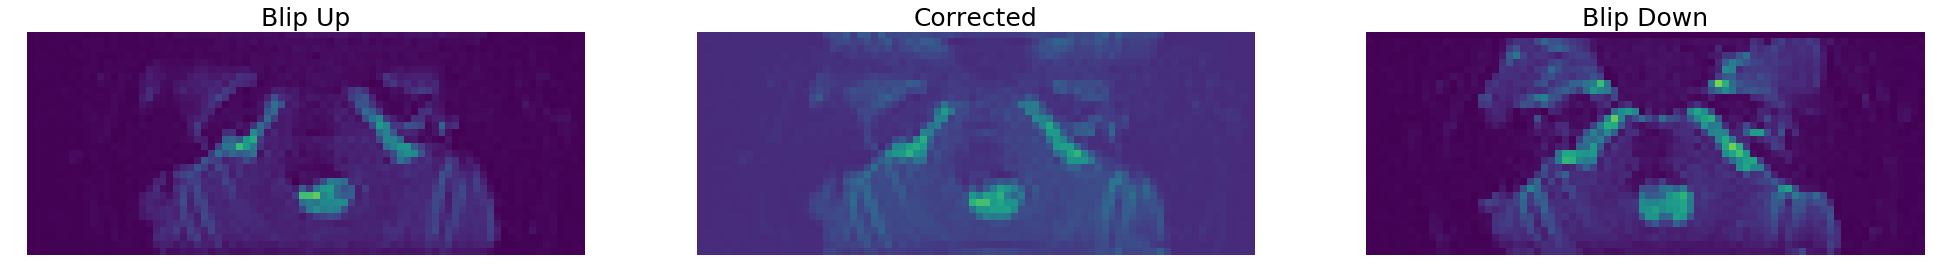

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(34, 10))

show_slice("dataset3/ep2ddiff60dir1avZoomItAPs004a001.nii.gz", z_locn=-6, t_idx=0, ax=axs[0])
show_slice("dataset3-out/data.nii.gz",    z_locn=-6, t_idx=0, ax=axs[1])
show_slice("dataset3/ep2ddiff60dir1avZoomItPAs010a001.nii.gz", z_locn=-6, t_idx=0, ax=axs[2])

for i, s in enumerate(['Blip Up', 'Corrected', 'Blip Down']):
    axs[i].set_title(s, fontsize=25)

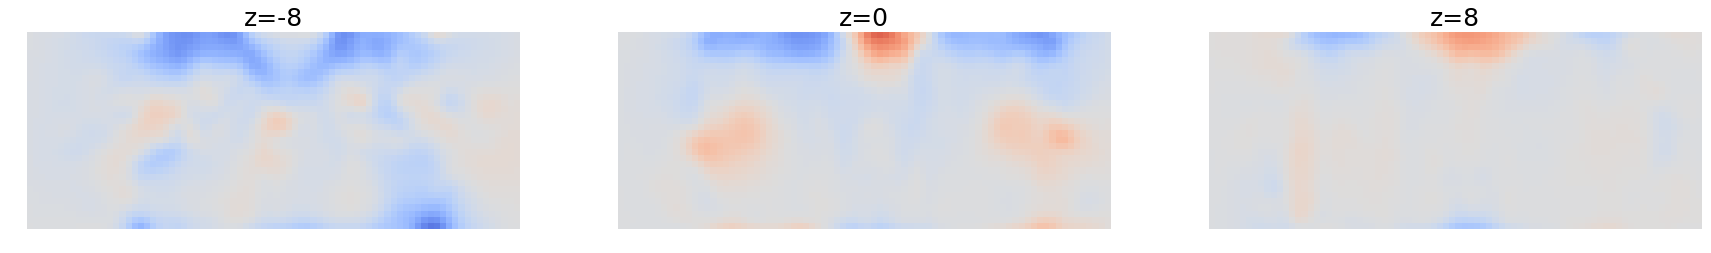

In [8]:
zs    = [-8, 0, 8]
figsz = 10
fig, axs = plt.subplots(1, len(zs), figsize=(figsz*len(zs), figsz))

for z, ax in zip(zs, axs):
    show_slice("dataset3-out/topup_field.nii.gz", z_locn=z, t_idx=0, cmap='coolwarm', centred=True, ax=ax)
    ax.set_title("z=%d" % z, fontsize=25)